### **CartPole-v1 (maximum 500 steps)**
#### Double Neural Network With Experience Replay (uses a Target Network to improve stability as Deep Mind did with Atari)
#### The updating of the Target Network is carried out less frequently. The online model gives us the action the agent is going to take next and the target network gives us the score of that action. This method helps avoid overestimates.
#### Two types of target-network-weights updating were compared: full updating and soft updating (tau = 0.5)
#### The input to the network consists of 4 float values (Cart Position, Cart Velocity, Pole Angle and Pole Velocity at the Tip).
#### The outputs of the network don't go through any activation function; instead of probabilities, the outputs are directly state-action values.
##### (The optimal policy involves choosing the Argmax of the output vector of the Neural Network as the action for the next step).
##### **This environment is considered to be solved when getting an average of 475 over 100 consecutive episodes.**

In [0]:
# Imports the libraries and creates the model
# Hyperparameter tuning was carried out for the model (learning_rate, optimizers, batch_size, etc.) and for the learning loop (number of replay steps, discount factor, epsilon_decay, etc.)


import random
import numpy as np
from tensorflow import keras
import gym
env = gym.make('CartPole-v1')
model = keras.Sequential()
model.add (keras.layers.Dense(units = 32, input_shape=(4,), activation = "relu"))
model.add (keras.layers.Dense(units = 32, activation = "relu"))
model.add (keras.layers.Dense(units = 8, activation = "relu"))
model.add (keras.layers.Dense(units = 8, activation = "relu"))
model.add (keras.layers.Dense(units = 2))
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss ="mse")
#print (model.summary())

# At first, the two models have the same parameters; however, the static model (target network) will be updated less frequently

staticModel = keras.models.clone_model( model, input_tensors=None, clone_function=None)
#print (staticModel.summary())

In [0]:
# Memory Replay is carried out in this function.
# 512 random previous experiences are "remembered" and processed in each step with a batch size of 128
# This way we can prevent overfitting most recent states
# This function has been vectorised with numpy "Put_along_axis" and "Take_along_axis" functions (see comment down below) to avoid a slow for loop.

def executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory):
    randomList = np.random.permutation(itemsInMemory) # After that number everything is 0
    
    memoryPreviousStates = memoryPreviousStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryStates = memoryStates[randomList[:numberOfLearningFromReplaySteps]]
    memoryARD = memoryARD[randomList[:numberOfLearningFromReplaySteps]]

    
    
    previousState = memoryPreviousStates
    
    state = memoryStates
    
    
    action, reward, done = np.split(memoryARD,3,axis=1)
    
    action = action.astype(int)
    
    target = model.predict(previousState)
    
    # Np.put_along_axis changes the value for the action selected in "action" into the "target" array.
    # I.e., for each row, one of the two columns are modified, these indexes (0 or 1) for each row appear in the "action" array
    # The individual updates are those of the Q-learning algorithm: only the reward obtained if done=False=0 and the reward plus the discounted value of the next state if done=True=1
    # However, given than now we have two networks, the online network will still use Argmax to choose the action to do in each future state but the value of such action is given by the staticModel instead.
    # This way, with Np.Take_long_axis, we take from the staticModelPredictions those indexes that correspond to the argmax of the predictions of the onlineModel for each future state. I.e, online model chooses an action and we take that index from the predictions of the static model for each future state:
    np.put_along_axis(target, action, (reward + (1-done)*discount*np.take_along_axis(staticModel.predict(state),np.expand_dims(np.argmax(model.predict(state), axis=1),axis=1),axis=1)), axis=1)
    
    
    targetArray = np.array(target)
    
    model.fit(memoryPreviousStates, targetArray, epochs=1, verbose = 0, batch_size =128)


## First trial: The static model is fully updated every 500 steps
#### (The static weights are replaced with those of the online model)

In [3]:
numberEpisodes = 1000

discount = 0.99
counter = 0
epsilon = 1
epsilonDecay = 0.995
rewards = []

memorySize = 5000
memoryPreviousStates = np.zeros((memorySize,4))
memoryStates = np.zeros((memorySize,4))
memoryARD = np.zeros((memorySize,3))
numberOfLearningFromReplaySteps = 512
itemsInMemory = 0
initialiseReplayAfter = 1000 

for episode in range (numberEpisodes):
    epsilon = max (epsilon*epsilonDecay, 0.1)
    
    
    done = False
    prevObs = env.reset()
    
    episodeReward = 0
    for step in range (600):
        if done:
            break
        #env.render()
        

        target = model.predict(np.expand_dims(prevObs, axis = 0))[0]
        if (random.random()<epsilon):
            action = random.choice([0,1])
        else:
            action = np.argmax(target)
        
        obs, reward, done, _ = env.step (action)


        memoryPreviousStates[counter] = prevObs
        memoryStates[counter] = obs
        if (episodeReward <= 498):
            memoryARD[counter] = [float(action), reward, float (done)]
        else: # Is not the fault of the agent's action that the environment restarts after 500 epochs. So we set done=False for the memory replay
            memoryARD[counter] = [float(action), reward, float (0)]
        
        if (counter%500 == 0):
            model.save_weights("weights.h5")
            staticModel.load_weights("weights.h5")
            print ("WEIGHTS SAVED")
        
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory)


        prevObs = obs
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)

env.close()
model.save_weights("weights.h5")

WEIGHTS SAVED
0  Episode Reward:  32.0 .Epsilon: 0.995
1  Episode Reward:  14.0 .Epsilon: 0.990025
2  Episode Reward:  17.0 .Epsilon: 0.985074875
3  Episode Reward:  16.0 .Epsilon: 0.9801495006250001
4  Episode Reward:  12.0 .Epsilon: 0.9752487531218751
5  Episode Reward:  40.0 .Epsilon: 0.9703725093562657
6  Episode Reward:  16.0 .Epsilon: 0.9655206468094844
7  Episode Reward:  11.0 .Epsilon: 0.960693043575437
8  Episode Reward:  48.0 .Epsilon: 0.9558895783575597
9  Episode Reward:  21.0 .Epsilon: 0.9511101304657719
10  Episode Reward:  15.0 .Epsilon: 0.946354579813443
11  Episode Reward:  14.0 .Epsilon: 0.9416228069143757
12  Episode Reward:  21.0 .Epsilon: 0.9369146928798039
13  Episode Reward:  12.0 .Epsilon: 0.9322301194154049
14  Episode Reward:  20.0 .Epsilon: 0.9275689688183278
15  Episode Reward:  26.0 .Epsilon: 0.9229311239742362
16  Episode Reward:  15.0 .Epsilon: 0.918316468354365
17  Episode Reward:  22.0 .Epsilon: 0.9137248860125932
18  Episode Reward:  9.0 .Epsilon: 0.90

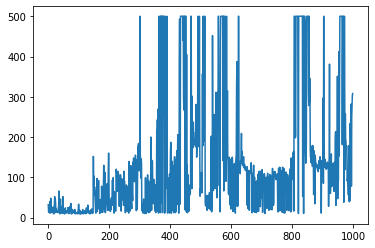

In [4]:
import matplotlib.pyplot as plt
plt.plot (list(range(len(rewards))), rewards)
plt.show()

### This algorithm seems more stable than the Single Network with and without Memory Replay.
# ------------------------------------------------------------------------------------------------

## Trial 2: Soft Updating with Tau = 0.5
### (Every 500 steps, the staticModel weights become the average of those of the static model and those of the online network)

In [3]:
# Function used to soft update the static Model weights for any given Tau

def updateStaticWeights(model, staticModel,tau):
    modelWeights = model.get_weights()
    staticWeights = staticModel.get_weights()
    
    #Python broadcasting:
    
    for i in range (len(staticWeights)):
     
        staticWeights[i] = (1-tau) * staticWeights[i] + tau * modelWeights[i]

        
    staticModel.set_weights(staticWeights)


    return model, staticModel

In [4]:
numberEpisodes = 1000

discount = 0.99
counter = 0
epsilon = 1
epsilonDecay = 0.995
rewards = []
tau = 0.5
memorySize = 5000
memoryPreviousStates = np.zeros((memorySize,4))
memoryStates = np.zeros((memorySize,4))
memoryARD = np.zeros((memorySize,3))
numberOfLearningFromReplaySteps = 512
itemsInMemory = 0
initialiseReplayAfter = 1000 

for episode in range (numberEpisodes):
    epsilon = max (epsilon*epsilonDecay, 0.1)
    
    
    done = False
    prevObs = env.reset()
    
    episodeReward = 0
    for step in range (600):
        if done:
            break
        #env.render()
        

        target = model.predict(np.expand_dims(prevObs, axis = 0))[0]
        if (random.random()<epsilon):
            action = random.choice([0,1])
        else:
            action = np.argmax(target)
        
        obs, reward, done, _ = env.step (action)


        memoryPreviousStates[counter] = prevObs
        memoryStates[counter] = obs
        if (episodeReward <= 498):
            memoryARD[counter] = [float(action), reward, float (done)]
        else: # Is not the fault of the agent's action that the environment restarts after 500 epochs. So we set done=False for the memory replay
            memoryARD[counter] = [float(action), reward, float (0)]
        
        if (counter % 500 == 0):
            
            model, staticModel = updateStaticWeights(model, staticModel,tau)
            print ("STATIC WEIGHTS UPDATED")
        
        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter):
            executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, staticModel, itemsInMemory)


        prevObs = obs
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)

env.close()
model.save_weights("doubleweights.h5")

STATIC WEIGHTS UPDATED
0  Episode Reward:  20.0 .Epsilon: 0.995
1  Episode Reward:  26.0 .Epsilon: 0.990025
2  Episode Reward:  32.0 .Epsilon: 0.985074875
3  Episode Reward:  25.0 .Epsilon: 0.9801495006250001
4  Episode Reward:  14.0 .Epsilon: 0.9752487531218751
5  Episode Reward:  33.0 .Epsilon: 0.9703725093562657
6  Episode Reward:  17.0 .Epsilon: 0.9655206468094844
7  Episode Reward:  16.0 .Epsilon: 0.960693043575437
8  Episode Reward:  23.0 .Epsilon: 0.9558895783575597
9  Episode Reward:  13.0 .Epsilon: 0.9511101304657719
10  Episode Reward:  10.0 .Epsilon: 0.946354579813443
11  Episode Reward:  10.0 .Epsilon: 0.9416228069143757
12  Episode Reward:  27.0 .Epsilon: 0.9369146928798039
13  Episode Reward:  11.0 .Epsilon: 0.9322301194154049
14  Episode Reward:  22.0 .Epsilon: 0.9275689688183278
15  Episode Reward:  21.0 .Epsilon: 0.9229311239742362
16  Episode Reward:  16.0 .Epsilon: 0.918316468354365
17  Episode Reward:  37.0 .Epsilon: 0.9137248860125932
18  Episode Reward:  19.0 .Eps

145  Episode Reward:  29.0 .Epsilon: 0.4810273709480478
STATIC WEIGHTS UPDATED
146  Episode Reward:  55.0 .Epsilon: 0.47862223409330756
147  Episode Reward:  125.0 .Epsilon: 0.47622912292284103
148  Episode Reward:  165.0 .Epsilon: 0.4738479773082268
149  Episode Reward:  22.0 .Epsilon: 0.47147873742168567
150  Episode Reward:  29.0 .Epsilon: 0.46912134373457726
151  Episode Reward:  13.0 .Epsilon: 0.46677573701590436
152  Episode Reward:  24.0 .Epsilon: 0.46444185833082485
153  Episode Reward:  10.0 .Epsilon: 0.46211964903917074
154  Episode Reward:  29.0 .Epsilon: 0.4598090507939749
STATIC WEIGHTS UPDATED
155  Episode Reward:  72.0 .Epsilon: 0.457510005540005
156  Episode Reward:  43.0 .Epsilon: 0.45522245551230495
157  Episode Reward:  32.0 .Epsilon: 0.4529463432347434
158  Episode Reward:  26.0 .Epsilon: 0.4506816115185697
159  Episode Reward:  34.0 .Epsilon: 0.4484282034609769
160  Episode Reward:  44.0 .Epsilon: 0.446186062443672
161  Episode Reward:  32.0 .Epsilon: 0.44395513213

286  Episode Reward:  16.0 .Epsilon: 0.23725980767521673
287  Episode Reward:  69.0 .Epsilon: 0.23607350863684065
STATIC WEIGHTS UPDATED
288  Episode Reward:  172.0 .Epsilon: 0.23489314109365644
289  Episode Reward:  37.0 .Epsilon: 0.23371867538818816
290  Episode Reward:  40.0 .Epsilon: 0.23255008201124722
291  Episode Reward:  254.0 .Epsilon: 0.231387331601191
292  Episode Reward:  44.0 .Epsilon: 0.23023039494318503
293  Episode Reward:  55.0 .Epsilon: 0.2290792429684691
294  Episode Reward:  43.0 .Epsilon: 0.22793384675362674
STATIC WEIGHTS UPDATED
295  Episode Reward:  23.0 .Epsilon: 0.22679417751985861
296  Episode Reward:  15.0 .Epsilon: 0.22566020663225933
297  Episode Reward:  10.0 .Epsilon: 0.22453190559909803
298  Episode Reward:  22.0 .Epsilon: 0.22340924607110255
299  Episode Reward:  72.0 .Epsilon: 0.22229219984074702
300  Episode Reward:  230.0 .Epsilon: 0.2211807388415433
301  Episode Reward:  37.0 .Epsilon: 0.22007483514733558
302  Episode Reward:  76.0 .Epsilon: 0.2189

421  Episode Reward:  11.0 .Epsilon: 0.12059799144222175
422  Episode Reward:  114.0 .Epsilon: 0.11999500148501063
STATIC WEIGHTS UPDATED
423  Episode Reward:  175.0 .Epsilon: 0.11939502647758558
424  Episode Reward:  110.0 .Epsilon: 0.11879805134519765
425  Episode Reward:  103.0 .Epsilon: 0.11820406108847166
426  Episode Reward:  46.0 .Epsilon: 0.1176130407830293
427  Episode Reward:  12.0 .Epsilon: 0.11702497557911415
428  Episode Reward:  161.0 .Epsilon: 0.11643985070121858
429  Episode Reward:  23.0 .Epsilon: 0.11585765144771248
STATIC WEIGHTS UPDATED
430  Episode Reward:  59.0 .Epsilon: 0.11527836319047392
431  Episode Reward:  24.0 .Epsilon: 0.11470197137452155
432  Episode Reward:  13.0 .Epsilon: 0.11412846151764894
433  Episode Reward:  34.0 .Epsilon: 0.1135578192100607
434  Episode Reward:  13.0 .Epsilon: 0.11299003011401039
435  Episode Reward:  117.0 .Epsilon: 0.11242507996344034
436  Episode Reward:  12.0 .Epsilon: 0.11186295456362313
437  Episode Reward:  82.0 .Epsilon: 0

STATIC WEIGHTS UPDATED
580  Episode Reward:  55.0 .Epsilon: 0.1
581  Episode Reward:  112.0 .Epsilon: 0.1
582  Episode Reward:  146.0 .Epsilon: 0.1
583  Episode Reward:  39.0 .Epsilon: 0.1
584  Episode Reward:  122.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
585  Episode Reward:  108.0 .Epsilon: 0.1
586  Episode Reward:  140.0 .Epsilon: 0.1
587  Episode Reward:  98.0 .Epsilon: 0.1
588  Episode Reward:  86.0 .Epsilon: 0.1
589  Episode Reward:  88.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
590  Episode Reward:  172.0 .Epsilon: 0.1
591  Episode Reward:  88.0 .Epsilon: 0.1
592  Episode Reward:  187.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
593  Episode Reward:  100.0 .Epsilon: 0.1
594  Episode Reward:  133.0 .Epsilon: 0.1
595  Episode Reward:  112.0 .Epsilon: 0.1
596  Episode Reward:  24.0 .Epsilon: 0.1
597  Episode Reward:  83.0 .Epsilon: 0.1
598  Episode Reward:  107.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
599  Episode Reward:  151.0 .Epsilon: 0.1
600  Episode Reward:  102.0 .Epsilon: 0.1
601  Episod

746  Episode Reward:  165.0 .Epsilon: 0.1
747  Episode Reward:  163.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
748  Episode Reward:  174.0 .Epsilon: 0.1
749  Episode Reward:  167.0 .Epsilon: 0.1
750  Episode Reward:  154.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
751  Episode Reward:  151.0 .Epsilon: 0.1
752  Episode Reward:  138.0 .Epsilon: 0.1
753  Episode Reward:  147.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
754  Episode Reward:  397.0 .Epsilon: 0.1
755  Episode Reward:  150.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
756  Episode Reward:  144.0 .Epsilon: 0.1
757  Episode Reward:  171.0 .Epsilon: 0.1
758  Episode Reward:  152.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
759  Episode Reward:  135.0 .Epsilon: 0.1
760  Episode Reward:  161.0 .Epsilon: 0.1
761  Episode Reward:  166.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
762  Episode Reward:  145.0 .Epsilon: 0.1
763  Episode Reward:  139.0 .Epsilon: 0.1
764  Episode Reward:  159.0 .Epsilon: 0.1
765  Episode Reward:  156.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED

STATIC WEIGHTS UPDATED
909  Episode Reward:  313.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
910  Episode Reward:  239.0 .Epsilon: 0.1
911  Episode Reward:  261.0 .Epsilon: 0.1
912  Episode Reward:  58.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
913  Episode Reward:  219.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
914  Episode Reward:  500.0 .Epsilon: 0.1
915  Episode Reward:  46.0 .Epsilon: 0.1
916  Episode Reward:  177.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
917  Episode Reward:  500.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
918  Episode Reward:  500.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
919  Episode Reward:  500.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
920  Episode Reward:  340.0 .Epsilon: 0.1
921  Episode Reward:  240.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
922  Episode Reward:  500.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
923  Episode Reward:  250.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
924  Episode Reward:  500.0 .Epsilon: 0.1
STATIC WEIGHTS UPDATED
925  Episode Reward:  500.0 .Epsilon: 0.1
STATIC WEIGH

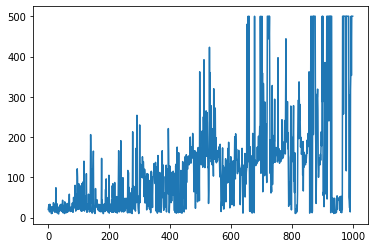

In [5]:
import matplotlib.pyplot as plt
plt.plot (list(range(len(rewards))), rewards)
plt.show()

## Even though there is still some "catastrophic forgetting", this is the most stable algorithm we have achieved for the CartPole. The trend slowly but steadily goes up as the agent is trained on more episodes

## The slower updating of the Target Network Weights with Tau altogether with bigger batch sizes seem to help prevent overestimates of certain actions in certain states, thus not forgetting was has already been learnt (catastrophic forgetting is quite frequent in Reinforcement Learning because the target keeps changing)